In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
import sys
import warnings
warnings.filterwarnings('ignore')

import time

from scipy.stats import ks_2samp
from scipy import integrate


from astropy.table import Table

homedir = os.getenv("HOME")



outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap.fits
number of lines in LCS cat =  2955
got sb flag
2759 2759 2759 2759
STD of pruned data = 0.18
STD of full data = 0.19
##################################
### FITTING WITH SIGMA CLIPPING 
##################################
Best-fit slope = 0.40
Best-fit inter = -4.16
Width of the MS = 0.19 (unclipped data)
###################################
### FITTING MS AFTER SIGMA CLIPPING 
###################################
Best-fit slope = 0.40+/-0.05
Best-fit inter = -4.16+/-0.54


<Figure size 489.6x360 with 0 Axes>

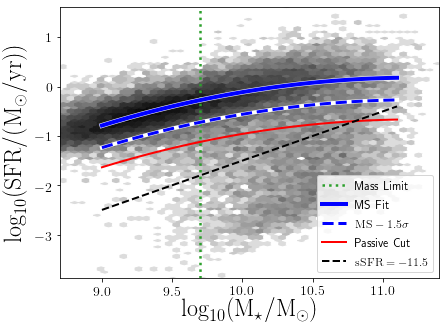

In [7]:
# plot main sequence
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 9.7 --ellip 0.75 --HIdef --minssfr -11.5
b.plot_full_ms()



In [134]:
from scipy.optimize import curve_fit
def gaussian(x,amplitude,center,sigma):
    return amplitude*(1/(sigma*(np.sqrt(2*np.pi))))*np.exp((-1.0/2.0)*((x-center)/sigma)**2)

def twogaussian(x_array, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen2)/sigma2)**2)))

def threegaussian(x_array, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen2)/sigma2)**2))) +\
            amp3*(1/(sigma3*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen3)/sigma3)**2)))

def gaussian1(x_array, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2))) 

def solve(m1,m2,std1,std2,amp1,amp2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1*amp1/amp2)
  return np.roots([a,b,c])

def get_MS(logMstar):
    return -0.1969*logMstar**2 + 4.4187*logMstar -24.607

def get_passive_cut(logMstar):
    return get_MS(logMstar) - 0.848 

In [168]:
def separate_sf(x,y,m1=9,m2=10.8,ms_slope=0.56,ms_intercept=-5.74,dm=.15,nbins=20,twogauss=True,passive_cut=.848):

    lowmass=m1
    highmass=m2
    minmass = np.arange(lowmass,highmass,dm)
    maxmass = np.arange(lowmass+dm,highmass+dm,dm)

    histbins=np.linspace(-3,1,nbins)
    plt.figure(figsize=(12,8))
    plt.subplots_adjust(hspace=.5,wspace=.35)
    nplot=1
    sfrcut_mass = []
    sfrcut_sfr = []
    lower_peak_sfr = []
    higher_peak_sfr = []
    higher_peak_std = []
    lower_peak_fit = []
    higher_peak_fit = []
    
    for m1,m2 in zip(minmass,maxmass):
        plt.subplot(4,4,nplot)
        flag = (x > m1) & (x < m2)
        # plot the data
        ybin,xbin_edge,t=plt.hist(y[flag],histtype='step',bins=histbins)
        xbin = (xbin_edge[:-1]+xbin_edge[1:])/2
        plt.title(r'$\rm {:.2f} < logMstar < {:.2f}$'.format(m1,m2),fontsize=14)
        

        xatmax= xbin[ybin == np.max(ybin)]
        xline=np.linspace(min(xbin),max(xbin),50)
        try:
            if twogauss:
                popt,pcov = curve_fit(twogaussian,xbin,ybin)
                yline = twogaussian(xline,*popt)
                if popt[1] > popt[4]:
                    
                    plt.plot(xline,gaussian1(xline,popt[0],popt[1],popt[2]),'b-')
                    plt.plot(xline,gaussian(xline,popt[3],popt[4],popt[5]),'r-')
                else:
                    plt.plot(xline,gaussian1(xline,popt[0],popt[1],popt[2]),'r-')
                    plt.plot(xline,gaussian(xline,popt[3],popt[4],popt[5]),'b-')
            else:
                popt,pcov = curve_fit(gaussian,xbin,ybin)
                yline = gaussian(xline,*popt)
                plt.plot(xline,gaussian1(xline,popt[0],popt[1],popt[2]),'b-')
                #plt.plot(xline,gaussian(xline,popt[3],popt[4],popt[5]),'c-')
                #plt.plot(xline,gaussian(xline,popt[6],popt[7],popt[8]),'g-')
        except:
            continue
        # plot combined gaussian
        plt.plot(xline,yline,'k--')
        # plot the two gaussians individually
        
        # find intersection of two gaussians
        # solve(m1,m2,std1,std2)
        if twogauss:
            #print(popt[1],popt[4],popt[2],popt[5],popt[0],popt[3])
            intersection = solve(popt[1],popt[4],popt[2],popt[5],popt[0],popt[3])
        
            # gaussians will likely have two points of intersection
            # use the minimum
            # if both are negative, then take the max
            if len(intersection) == 2:
                if (intersection[0] < 0) & (intersection[1] < 0):
                    sfr = np.max(intersection)
                else:
                    sfr = np.min(intersection)
        

                #plt.axvline(x=sfr, ls='--',c='k')
                sfrcut_mass.append(0.5*(m1+m2))
                sfrcut_sfr.append(sfr)
           
            
                lower_peak_sfr.append(np.min([popt[1],popt[4]]))
                higher_peak_sfr.append(np.max([popt[1],popt[4]]))
                if popt[1] > popt[4]:
                    higher_peak_std.append(popt[2])
                    higher_peak_fit.append([popt[0],popt[1],popt[2]])
                    lower_peak_fit.append([popt[3],popt[4],popt[5]])
                else:
                    higher_peak_std.append(popt[5])
                    lower_peak_fit.append([popt[0],popt[1],popt[2]])
                    higher_peak_fit.append([popt[3],popt[4],popt[5]])
        else:
            sfrcut_mass.append(0.5*(m1+m2))
            higher_peak_sfr.append(popt[1])
            higher_peak_std.append(popt[2])
            
            #sfrcut_sfr.append(popt[1])
            #higher_peak_std.append(popt[2])
        if nplot > 6:
            plt.xlabel(r'$\rm \log_{10}(SFR)$',fontsize=14)
        # add vertical line showing sSFR = -11.5
        sfr_limit = get_passive_cut(0.5*(m1+m2))
        plt.axvline(x=sfr_limit,ls=':')
        nplot += 1
    

    sfrcut_mass = np.array(sfrcut_mass)
    sfrcut_sfr = np.array(sfrcut_sfr)
    
   
    higher_peak_std = np.array(higher_peak_std)
    higher_peak_sfr = np.array(higher_peak_sfr)
  

    plt.savefig('sfpeaks_2gauss.png')
    plt.savefig('sfpeaks_2gauss.pdf')
    ################################
    ######### OTHER PLOTS ##########
    ################################
    
    plt.figure()
    plt.plot(sfrcut_mass,higher_peak_sfr,'bo')
    
    # FIT MAIN SEQUENCE
    flag = (sfrcut_mass < 12) & (sfrcut_mass > 8)
    c,cov = np.polyfit(sfrcut_mass[flag],higher_peak_sfr[flag],2,cov=True)
    xline = np.linspace(lowmass,highmass,100)
    yline = np.polyval(c,xline)
    plt.plot(xline,yline,'r--')
    plt.xlabel('log Mass')
    plt.ylabel('Center of SF peak')
    print('SFR-Mstar best fit line : ',c)
    s = "sqrt of cov matrix = "
    for i in range(cov.shape[0]):
        s = s + ", {:.3e}".format(cov[i][i])
    print(s)
    
    # FILL BETWEEN +/- 1.5 SIGMA
    sigma=.3
    plt.fill_between(xline,yline+1.5*sigma,yline-1.5*sigma,label='+/-1.5 sigma',alpha=.2,color='r')

    # PLOT MS FIT - 0.67
    
    plt.plot(xline,yline-passive_cut,'c-',label='MS - {}'.format(passive_cut))
    # PLOT THE SSFR CUT FROM SALIM
    plt.plot(xline,xline-11.5,'k--',label='sSFR=-11.5')
    plt.legend()
   
    # plot std from the MS
    plt.figure()

    plt.plot(sfrcut_mass,higher_peak_std,'bo')
    plt.xlabel('log Mass')
    plt.ylabel('STD of MS')

    print('mean STD of MS = {:.2f}'.format(np.mean(higher_peak_std)))
    print('median STD of MS = {:.2f}'.format(np.median(higher_peak_std)))
    
    if twogauss:
         # plot intersection of two gaussians vs stellar mass
        plt.figure()
        plt.plot(sfrcut_mass,sfrcut_sfr,'bo')
        plt.xlabel('log Mass')
        plt.ylabel('SFR where gaussians intersect')
        print("average SFR of where gaussians overlap = {:.2f}".format(np.mean(sfrcut_sfr)))
        print("median SFR of where gaussians overlap = {:.2f}".format(np.median(sfrcut_sfr)))
    
        # plot offset from the MS
        plt.figure()
        sfroffset = sfrcut_sfr - get_MS(sfrcut_mass)
        plt.plot(sfrcut_mass,sfroffset,'bo')
        plt.xlabel('log Mass')
        plt.ylabel('SFR offset from MS')

        print('mean offset from MS = {:.2f}'.format(np.mean(sfroffset[sfrcut_mass > 9.7])))
        print('median offset from MS = {:.2f}'.format(np.median(sfroffset[sfrcut_mass > 9.7])))
        
        # plot std from the MS
        plt.figure()

        plt.plot(sfrcut_mass,sfroffset/higher_peak_std,'bo')
        plt.xlabel('log Mass')
        plt.ylabel('Offset from MS / STD of MS')

        print('median Zscore of offset = {:.2f}'.format(np.median(sfroffset/higher_peak_std)))

    return minmass,maxmass,lower_peak_fit,higher_peak_fit
    

    


# Using field sample from paper to fit MS

outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap.fits
number of lines in LCS cat =  2955
got sb flag
2759 2759 2759 2759
SFR-Mstar best fit line :  [ -0.19689988   4.4186588  -24.60739556]
sqrt of cov matrix = , 3.073e-03, 1.230e+00, 3.061e+01
mean STD of MS = 0.29
median STD of MS = 0.29
average SFR of where gaussians overlap = -0.52
median SFR of where gaussians overlap = -0.52
mean offset from MS = -0.64
median offset from MS = -0.60
median Zscore of offset = -1.70


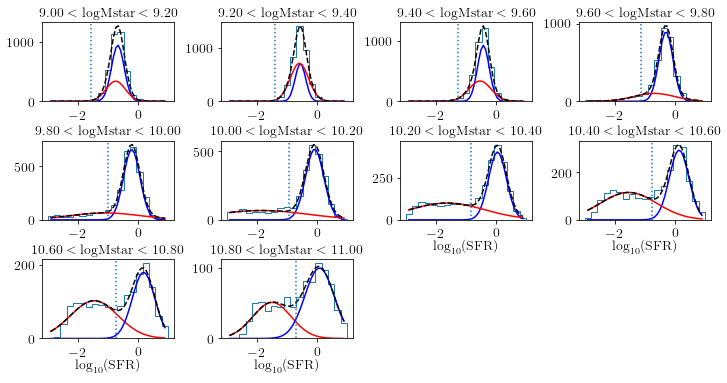

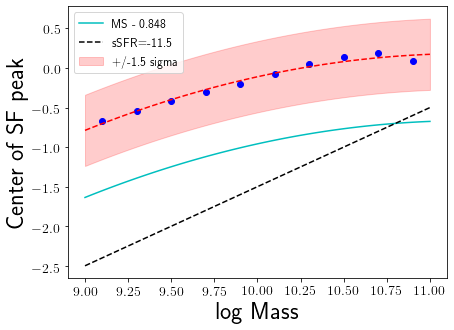

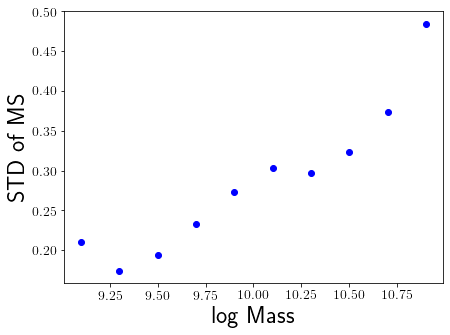

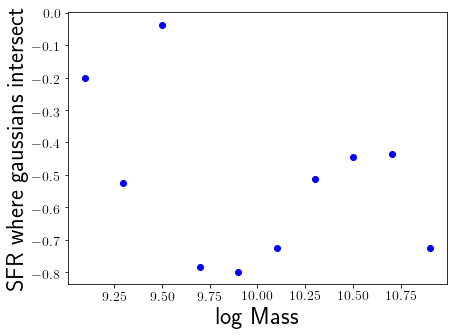

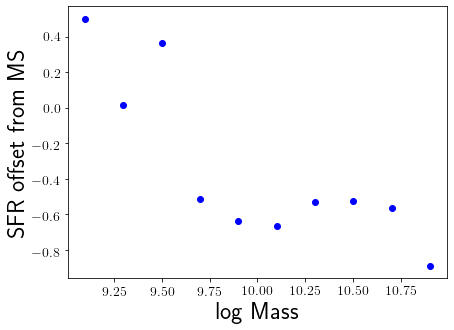

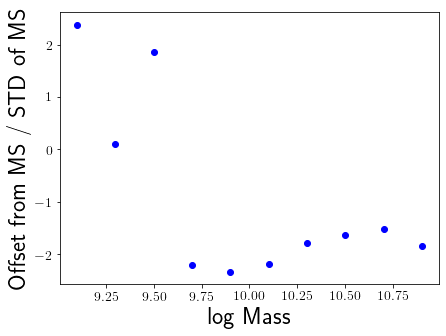

In [203]:
# plot main sequence
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 8.7 --ellip 0.75 --HIdef --minssfr -11.5

t = separate_sf(b.gsw.cat['logMstar'],b.gsw.cat['logSFR'],m1=9.,m2=11,ms_slope=0.592,ms_intercept=-6.05,dm=.2)
plt.savefig('sfpeak_field.png')
plt.savefig('sfpeak_field.pdf')

In [176]:
flag =   (b.gsw.cat['logMstar'] > 9.7) & (b.gsw.cat['logSFR']-b.gsw.cat['logMstar'] > -11.5)
logmstar = b.gsw.cat['logMstar'][flag]
from scipy.stats import scoreatpercentile
print("percentile mass of field sample = {:.3f}".format(scoreatpercentile(logmstar,95)))

percentile mass of field sample = 10.844


In [177]:
logmass = 10.8
yms = -.1968999*logmass**2+4.4186588*logmass-24.61
print('SFR at logmass = {:.3f}'.format(yms))
print("offset b/w MS and sSFR=-11.5 = {:.3f} ".format(yms- (logmass-11.5)))
print("offset relative to MS sigma = {:.3f}".format((yms- (logmass-11.5))/.3))

SFR at logmass = 0.145
offset b/w MS and sSFR=-11.5 = 0.845 
offset relative to MS sigma = 2.817


# using B/T < 0.3 field sample from paper to fit MS

outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap-BTcut.fits
number of lines in LCS cat =  2955
inside LCS cut_BT, BT =  0.3
inside LCS cut_BT, BTkey =  __B_T_r
got sb flag
1305 1305 1305 1305
SFR-Mstar best fit line :  [ -0.09492558   2.45919124 -15.23137515]
sqrt of cov matrix = , 4.204e-04, 1.683e-01, 4.187e+00
mean STD of MS = 0.27
median STD of MS = 0.28


<Figure size 489.6x360 with 0 Axes>

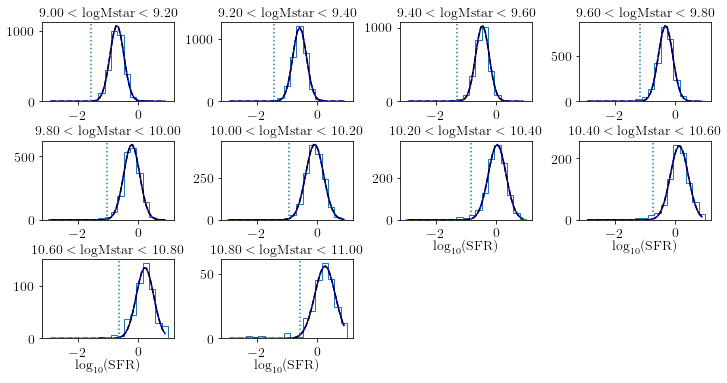

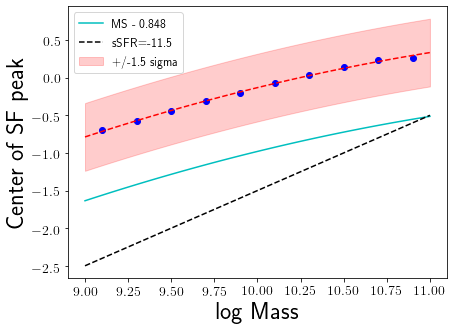

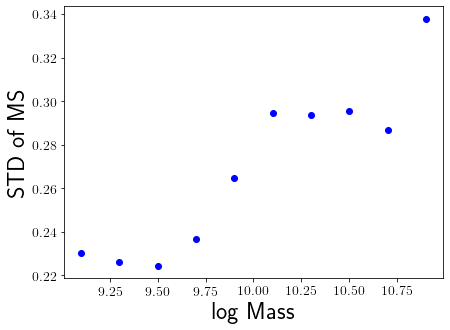

In [209]:
# plot main sequence
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 8.7 --ellip 0.75 --HIdef --minssfr -14 --cutBT --BT 0.3

t = separate_sf(b.gsw.cat['logMstar'],b.gsw.cat['logSFR'],m1=9.,m2=11,ms_slope=0.592,ms_intercept=-6.05,dm=.2,twogauss=False)
plt.savefig('sfpeak_field_BT.png')
plt.savefig('sfpeak_field_BT.pdf')

In [220]:
b.gsw = gswBTcut
flag =   (gswBTcut['logMstar'] > 9.7) & (gswBTcut['logSFR']- gswBTcut['logMstar'] > -11.5)
logmstar = gswBTcut['logMstar'][flag]
from scipy.stats import scoreatpercentile
print("percentile mass of field sample = {:.3f}".format(scoreatpercentile(logmstar,95)))

percentile mass of field sample = 10.755


In [221]:
logmass = 10.8
yms = -0.1045*logmass**2+2.645*logmass-16.13
print("offset b/w MS and sSFR=-11.5 = {:.3f} ".format(yms- (logmass-11.5)))
print("offset relative to MS sigma = {:.3f}".format((yms- (logmass-11.5))/.3))

offset b/w MS and sSFR=-11.5 = 0.947 
offset relative to MS sigma = 3.157


In [216]:
10**.9

7.943282347242816

# Specific Star-Formation Rates

In [ ]:
# our sample w/out B/T cut to get the field sample fits
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 9.7 --ellip 0.75 --HIdef --minssfr -11.5

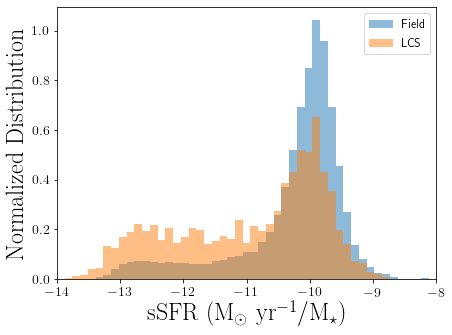

In [191]:


mybins = np.linspace(-14,-8,50)
x =b.gsw.cat['logMstar']
y=b.gsw.cat['logSFR']-b.gsw.cat['logMstar']
plt.figure()
t=plt.hist(y,bins=mybins,normed=True,alpha=.5,label='Field')

x =b.lcs.cat['logMstar']
y=b.lcs.cat['logSFR']-b.lcs.cat['logMstar']
flag = b.lcs.membflag | b.lcs.infallflag
t=plt.hist(y,bins=mybins,normed=True,alpha=.5,label='LCS')
plt.xlim(-14,-8)
plt.xlabel(r'$\rm sSFR \ (M_\odot~yr^{-1}/M_\star)$')
plt.ylabel(r'$\rm Normalized \ Distribution$')
plt.legend()

# Estimating Contamination from Passive Galaxies

* for masses between 9.7 and 11
  * calc integral below passive cut and integral above passive cut
    * save as int_below, int_above
  * for each mass bin in LCS core, get number of galaxies in our sample below the passive cut
  * scale factor is nlcs_below/int_below
  * contamination is scale x int_above
  * save Ncontam and mass
  
  

## Using field to fit double gaussian

outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap.fits
number of lines in LCS cat =  2955
got sb flag
2759 2759 2759 2759
SFR-Mstar best fit line :  [ -0.17523136   3.97752343 -22.37493591]
sqrt of cov matrix = , 2.878e-03, 1.152e+00, 2.865e+01
mean STD of MS = 0.28
median STD of MS = 0.29
average SFR of where gaussians overlap = -0.57+0.02j
median SFR of where gaussians overlap = -0.59+0.00j
mean offset from MS = -0.62+0.00j
median offset from MS = -0.61+0.00j
median Zscore of offset = -1.90+0.00j


<Figure size 489.6x360 with 0 Axes>

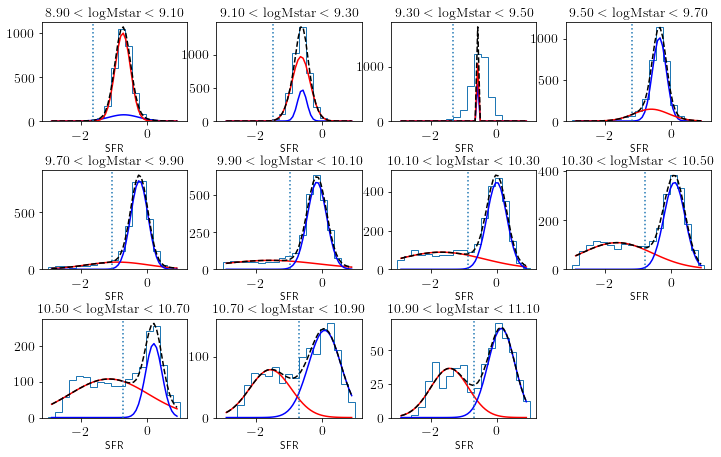

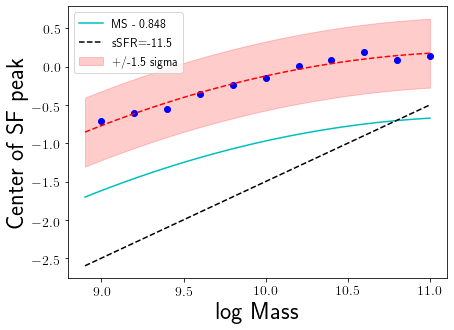

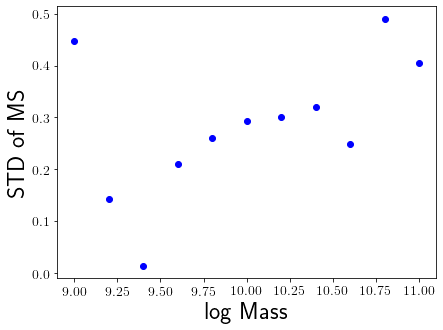

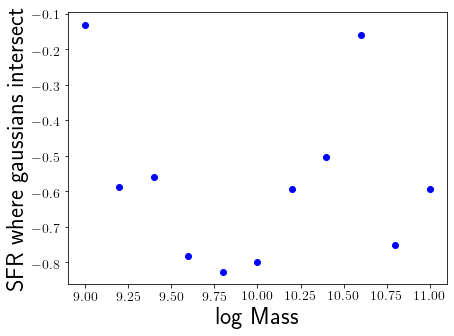

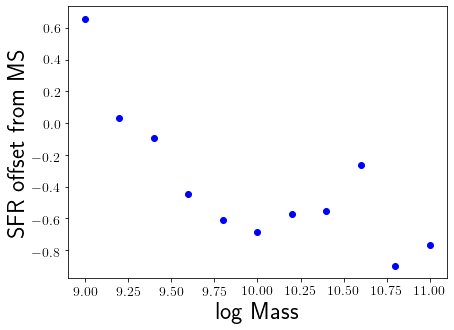

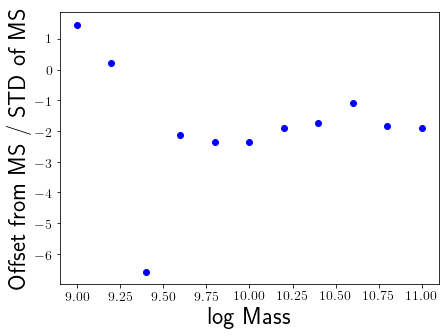

In [113]:
# our sample w/out B/T cut to get the field sample fits
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 9.7 --ellip 0.75 --HIdef --minssfr -11.5

gauss_minmass,gauss_maxmass,lower_peak_fit,higher_peak_fit = separate_sf(b.gsw.cat['logMstar'],b.gsw.cat['logSFR'],m1=8.9,m2=11,ms_slope=0.592,ms_intercept=-6.05,dm=.2)

# run again with BT cut so we can determine contamination in BT < 0.3 sample
#%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 9.7 --ellip 0.75 --HIdef --minssfr -11.5 --cutBT --BT 0.3



# Estimating Contamination from Passive Population

In [179]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 9.7 --ellip 0.75 --HIdef --minssfr -11.5 --cutBT --BT 0.3

outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap-BTcut.fits
number of lines in LCS cat =  2955
inside LCS cut_BT, BT =  0.3
inside LCS cut_BT, BTkey =  __B_T_r
got sb flag
1305 1305 1305 1305


12 31 4
15 18 1
17 16 3
5 8 1
2 7 2
0 2 1
0 2 1


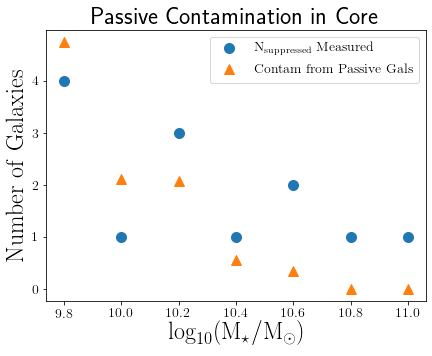

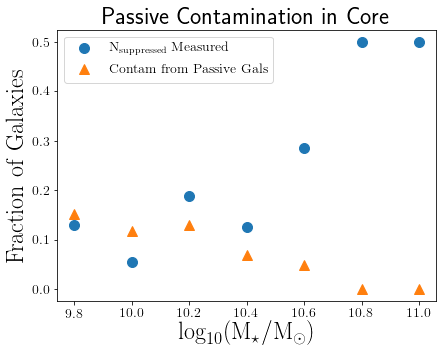

In [180]:
logMstar = []
Ncontam = []
Nsf_lcs = []
Nsuppressed_lcs = []
Nsf_lcs = []

dsfr = b.lcs.cat['logSFR'] - get_MS(b.lcs.cat['logMstar'])
lcsflag = b.lcs.membflag
label='Core'
all_passive = b.lcs.cat['logSFR'] < get_SFR_cut(b.lcs.cat['logMstar'])
all_sf = b.lcs.cat['logSFR'] > get_SFR_cut(b.lcs.cat['logMstar'])
for i,gaussfit in enumerate(lower_peak_fit):
    if gauss_minmass[i] < 9.65:
        #print(gauss_minmass[i])
        continue
    avemass = 0.5*(gauss_minmass[i]+gauss_maxmass[i])
    
    # get number of LCS galaxies in mass range and below passive cut
    mass_flag =  (b.lcs.cat['logMstar'] > gauss_minmass[i]) & (b.lcs.cat['logMstar'] <= gauss_maxmass[i]) 
    
    sfrcut = get_SFR_cut(avemass)
    #print('sfrcut = ',sfrcut)
    
    passive_flag =  all_passive & mass_flag & lcsflag
    
    sf_flag = all_sf & mass_flag & lcsflag
    #print(dsfr[sf_flag])
    #print(len(dsfr[sf_flag]),np.sum(dsfr[sf_flag] < -0.45))
    suppressed_flag = sf_flag & (dsfr < -1*MS_OFFSET)
    print(sum(passive_flag),sum(sf_flag),sum(suppressed_flag))
    # integrate gauss fit below
    int_below = integrate.quadrature(gaussian1,-10,sfrcut,tuple(gaussfit))[0]
    # integrate gauss fit below
    int_above = integrate.quadrature(gaussian1,sfrcut,10,tuple(gaussfit))[0]
    
    # integrate to get the number in the passive slice, not all galaxies about passive cut
    upper_limit = get_MS(avemass) - MS_OFFSET
    int_above = integrate.quadrature(gaussian1,sfrcut,upper_limit,tuple(gaussfit))[0]
    
    
 
    flag = lcsflag & mass_flag & passive_flag
    N_lcs_passive = np.sum(flag)
    
    Nsuppressed_lcs.append(np.sum(suppressed_flag))
    Nsf_lcs.append(np.sum(sf_flag))
    scale = N_lcs_passive/int_below
    
    Ncontam.append(scale*int_above)
    logMstar.append(avemass)
    
Nsuppressed_lcs = np.array(Nsuppressed_lcs)
Nsf_lcs = np.array(Nsf_lcs)
Ncontam = np.array(Ncontam)
plt.figure()
plt.plot(logMstar,Nsuppressed_lcs,'o',label=r'$\rm N_{suppressed} \ Measured$',markersize=10)
plt.plot(logMstar,Ncontam,'^',label=r'$\rm Contam \ from \ Passive \ Gals$',markersize=10)

plt.xlabel(r'$\rm \log_{10}(M_\star/M_\odot)$')
plt.ylabel(r'$\rm Number \ of \ Galaxies$')
plt.title('Passive Contamination in '+label)
s = 'Total Contam = {:.1f}'.format(np.sum(Ncontam))
#plt.text(0.9,0.5,s,transform=plt.gca().transAxes,horizontalalignment='right')
plt.legend(fontsize=14)


plt.figure()
plt.plot(logMstar,Nsuppressed_lcs/Nsf_lcs,'o',label=r'$\rm N_{suppressed} \ Measured$',markersize=10)
plt.plot(logMstar,Ncontam/Nsf_lcs,'^',label=r'$\rm Contam \ from \ Passive \ Gals$',markersize=10)

plt.xlabel(r'$\rm \log_{10}(M_\star/M_\odot)$')
plt.ylabel(r'$\rm Fraction \ of \ Galaxies$')
plt.title('Passive Contamination in '+label)
s = 'Total Contam = {:.1f}'.format(np.sum(Ncontam))
#plt.text(0.9,0.5,s,transform=plt.gca().transAxes,horizontalalignment='right')
plt.legend(fontsize=14)



16 73 8
16 37 3
8 38 7
3 32 5
4 22 2
2 11 4
3 1 0


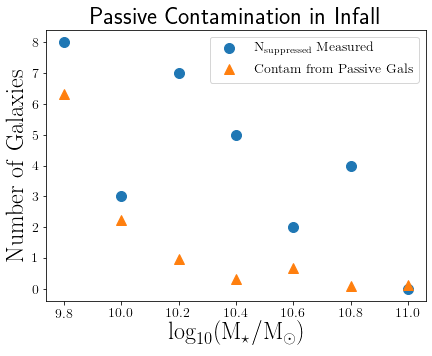

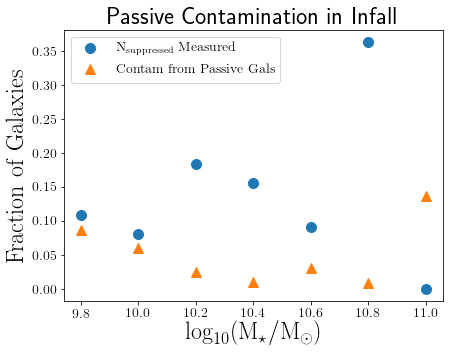

In [181]:
logMstar = []
Ncontam = []
Nsf_lcs = []
Nsuppressed_lcs = []
Nsf_lcs = []

dsfr = b.lcs.cat['logSFR'] - get_MS(b.lcs.cat['logMstar'])
lcsflag = b.lcs.infallflag
label='Infall'
all_passive = b.lcs.cat['logSFR'] < get_SFR_cut(b.lcs.cat['logMstar'])
all_sf = b.lcs.cat['logSFR'] > get_SFR_cut(b.lcs.cat['logMstar'])
for i,gaussfit in enumerate(lower_peak_fit):
    if gauss_minmass[i] < 9.65:
        #print(gauss_minmass[i])
        continue
    avemass = 0.5*(gauss_minmass[i]+gauss_maxmass[i])
    
    # get number of LCS galaxies in mass range and below passive cut
    mass_flag =  (b.lcs.cat['logMstar'] > gauss_minmass[i]) & (b.lcs.cat['logMstar'] <= gauss_maxmass[i]) 
    
    sfrcut = get_SFR_cut(avemass)
    #print('sfrcut = ',sfrcut)
    
    passive_flag =  all_passive & mass_flag & lcsflag
    
    sf_flag = all_sf & mass_flag & lcsflag
    #print(dsfr[sf_flag])
    #print(len(dsfr[sf_flag]),np.sum(dsfr[sf_flag] < -0.45))
    suppressed_flag = sf_flag & (dsfr < -1*MS_OFFSET)
    print(sum(passive_flag),sum(sf_flag),sum(suppressed_flag))
    # integrate gauss fit below
    int_below = integrate.quadrature(gaussian1,-10,sfrcut,tuple(gaussfit))[0]
    # integrate gauss fit below
    int_above = integrate.quadrature(gaussian1,sfrcut,10,tuple(gaussfit))[0]
    
    # integrate to get the number in the passive slice, not all galaxies about passive cut
    upper_limit = get_MS(avemass) - MS_OFFSET
    int_above = integrate.quadrature(gaussian1,sfrcut,upper_limit,tuple(gaussfit))[0]
    
    
 
    flag = lcsflag & mass_flag & passive_flag
    N_lcs_passive = np.sum(flag)
    
    Nsuppressed_lcs.append(np.sum(suppressed_flag))
    Nsf_lcs.append(np.sum(sf_flag))
    scale = N_lcs_passive/int_below
    
    Ncontam.append(scale*int_above)
    logMstar.append(avemass)
    
Nsuppressed_lcs = np.array(Nsuppressed_lcs)
Nsf_lcs = np.array(Nsf_lcs)
Ncontam = np.array(Ncontam)
plt.figure()
plt.plot(logMstar,Nsuppressed_lcs,'o',label=r'$\rm N_{suppressed} \ Measured$',markersize=10)
plt.plot(logMstar,Ncontam,'^',label=r'$\rm Contam \ from \ Passive \ Gals$',markersize=10)

plt.xlabel(r'$\rm \log_{10}(M_\star/M_\odot)$')
plt.ylabel(r'$\rm Number \ of \ Galaxies$')
plt.title('Passive Contamination in '+label)
s = 'Total Contam = {:.1f}'.format(np.sum(Ncontam))
#plt.text(0.9,0.5,s,transform=plt.gca().transAxes,horizontalalignment='right')
plt.legend(fontsize=14)


plt.figure()
plt.plot(logMstar,Nsuppressed_lcs/Nsf_lcs,'o',label=r'$\rm N_{suppressed} \ Measured$',markersize=10)
plt.plot(logMstar,Ncontam/Nsf_lcs,'^',label=r'$\rm Contam \ from \ Passive \ Gals$',markersize=10)

plt.xlabel(r'$\rm \log_{10}(M_\star/M_\odot)$')
plt.ylabel(r'$\rm Fraction \ of \ Galaxies$')
plt.title('Passive Contamination in '+label)
s = 'Total Contam = {:.1f}'.format(np.sum(Ncontam))
#plt.text(0.9,0.5,s,transform=plt.gca().transAxes,horizontalalignment='right')
plt.legend(fontsize=14)



28 104 12
31 55 4
25 54 10
8 40 6
6 29 4
2 13 5
3 3 1


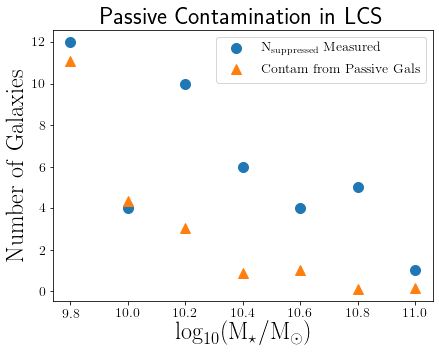

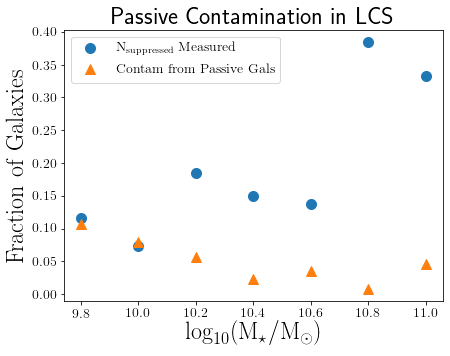

In [182]:
logMstar = []
Ncontam = []
Nsf_lcs = []
Nsuppressed_lcs = []
Nsf_lcs = []

dsfr = b.lcs.cat['logSFR'] - get_MS(b.lcs.cat['logMstar'])
lcsflag = b.lcs.infallflag | b.lcs.membflag
label='LCS'
all_passive = b.lcs.cat['logSFR'] < get_SFR_cut(b.lcs.cat['logMstar'])
all_sf = b.lcs.cat['logSFR'] > get_SFR_cut(b.lcs.cat['logMstar'])
for i,gaussfit in enumerate(lower_peak_fit):
    if gauss_minmass[i] < 9.65:
        #print(gauss_minmass[i])
        continue
    avemass = 0.5*(gauss_minmass[i]+gauss_maxmass[i])
    
    # get number of LCS galaxies in mass range and below passive cut
    mass_flag =  (b.lcs.cat['logMstar'] > gauss_minmass[i]) & (b.lcs.cat['logMstar'] <= gauss_maxmass[i]) 
    
    sfrcut = get_SFR_cut(avemass)
    #print('sfrcut = ',sfrcut)
    
    passive_flag =  all_passive & mass_flag & lcsflag
    
    sf_flag = all_sf & mass_flag & lcsflag
    #print(dsfr[sf_flag])
    #print(len(dsfr[sf_flag]),np.sum(dsfr[sf_flag] < -0.45))
    suppressed_flag = sf_flag & (dsfr < -1*MS_OFFSET)
    print(sum(passive_flag),sum(sf_flag),sum(suppressed_flag))
    # integrate gauss fit below
    int_below = integrate.quadrature(gaussian1,-10,sfrcut,tuple(gaussfit))[0]
    # integrate gauss fit below
    int_above = integrate.quadrature(gaussian1,sfrcut,10,tuple(gaussfit))[0]
    
    # integrate to get the number in the passive slice, not all galaxies about passive cut
    upper_limit = get_MS(avemass) - MS_OFFSET
    int_above = integrate.quadrature(gaussian1,sfrcut,upper_limit,tuple(gaussfit))[0]
    
    
 
    flag = lcsflag & mass_flag & passive_flag
    N_lcs_passive = np.sum(flag)
    
    Nsuppressed_lcs.append(np.sum(suppressed_flag))
    Nsf_lcs.append(np.sum(sf_flag))
    scale = N_lcs_passive/int_below
    
    Ncontam.append(scale*int_above)
    logMstar.append(avemass)
    
Nsuppressed_lcs = np.array(Nsuppressed_lcs)
Nsf_lcs = np.array(Nsf_lcs)
Ncontam = np.array(Ncontam)
plt.figure()
plt.plot(logMstar,Nsuppressed_lcs,'o',label=r'$\rm N_{suppressed} \ Measured$',markersize=10)
plt.plot(logMstar,Ncontam,'^',label=r'$\rm Contam \ from \ Passive \ Gals$',markersize=10)

plt.xlabel(r'$\rm \log_{10}(M_\star/M_\odot)$')
plt.ylabel(r'$\rm Number \ of \ Galaxies$')
plt.title('Passive Contamination in '+label)
s = 'Total Contam = {:.1f}'.format(np.sum(Ncontam))
#plt.text(0.9,0.5,s,transform=plt.gca().transAxes,horizontalalignment='right')
plt.legend(fontsize=14)


plt.figure()
plt.plot(logMstar,Nsuppressed_lcs/Nsf_lcs,'o',label=r'$\rm N_{suppressed} \ Measured$',markersize=10)
plt.plot(logMstar,Ncontam/Nsf_lcs,'^',label=r'$\rm Contam \ from \ Passive \ Gals$',markersize=10)

plt.xlabel(r'$\rm \log_{10}(M_\star/M_\odot)$')
plt.ylabel(r'$\rm Fraction \ of \ Galaxies$')
plt.title('Passive Contamination in '+label)
s = 'Total Contam = {:.1f}'.format(np.sum(Ncontam))
#plt.text(0.9,0.5,s,transform=plt.gca().transAxes,horizontalalignment='right')
plt.legend(fontsize=14)
lcsMstar = logMstar
lcsNsuppressed = Nsuppressed_lcs
lcsNsf = Nsf_lcs
lcsNcontam = Ncontam


In [1]:
Nsupp = 10+6+4+5+1
Ncont = 3+1+1+0+0
Ncont/Nsupp

0.19230769230769232

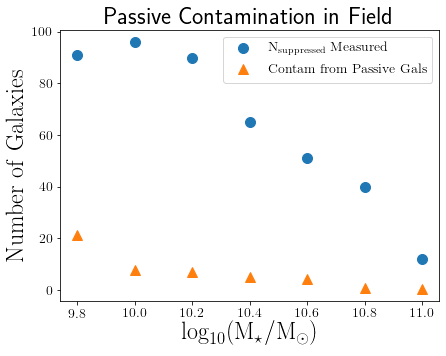

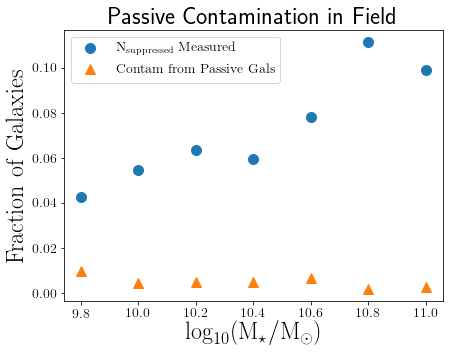

In [183]:
# what about for field?
logMstar = []
Ncontam = []
Nsf_lcs = []
Nsuppressed_lcs = []
Nsf_lcs = []

cat = b.gsw.cat

dsfr = cat['logSFR'] - get_MS(cat['logMstar'])
lcsflag = np.ones(len(cat),'bool')
label='Field'
all_passive = cat['logSFR'] < get_SFR_cut(cat['logMstar'])
all_sf = cat['logSFR'] > get_SFR_cut(cat['logMstar'])
for i,gaussfit in enumerate(lower_peak_fit):
    if gauss_minmass[i] < 9.65:
        #print(gauss_minmass[i])
        continue
    avemass = 0.5*(gauss_minmass[i]+gauss_maxmass[i])
    
    # get number of LCS galaxies in mass range and below passive cut
    mass_flag =  (cat['logMstar'] > gauss_minmass[i]) & (cat['logMstar'] <= gauss_maxmass[i]) 
    
    sfrcut = get_SFR_cut(avemass)
    #print('sfrcut = ',sfrcut)
    
    passive_flag =  all_passive & mass_flag & lcsflag
    
    sf_flag = all_sf & mass_flag & lcsflag
    #print(dsfr[sf_flag])
    #print(len(dsfr[sf_flag]),np.sum(dsfr[sf_flag] < -0.45))
    suppressed_flag = sf_flag & (dsfr < -1*MS_OFFSET)
    #print(sum(passive_flag),sum(sf_flag),sum(suppressed_flag))
    # integrate gauss fit below
    int_below = integrate.quadrature(gaussian1,-10,sfrcut,tuple(gaussfit))[0]
    # integrate gauss fit below
    int_above = integrate.quadrature(gaussian1,sfrcut,10,tuple(gaussfit))[0]
    
    # integrate to get the number in the passive slice, not all galaxies about passive cut
    upper_limit = get_MS(avemass) - MS_OFFSET
    int_above = integrate.quadrature(gaussian1,sfrcut,upper_limit,tuple(gaussfit))[0]
    
    
 
    flag = lcsflag & mass_flag & passive_flag
    N_lcs_passive = np.sum(flag)
    
    Nsuppressed_lcs.append(np.sum(suppressed_flag))
    Nsf_lcs.append(np.sum(sf_flag))
    scale = N_lcs_passive/int_below
    
    Ncontam.append(scale*int_above)
    logMstar.append(avemass)
    
Nsuppressed_lcs = np.array(Nsuppressed_lcs)
Nsf_lcs = np.array(Nsf_lcs)
Ncontam = np.array(Ncontam)
plt.figure()
plt.plot(logMstar,Nsuppressed_lcs,'o',label=r'$\rm N_{suppressed} \ Measured$',markersize=10)
plt.plot(logMstar,Ncontam,'^',label=r'$\rm Contam \ from \ Passive \ Gals$',markersize=10)

plt.xlabel(r'$\rm \log_{10}(M_\star/M_\odot)$')
plt.ylabel(r'$\rm Number \ of \ Galaxies$')
plt.title('Passive Contamination in '+label)
s = 'Total Contam = {:.1f}'.format(np.sum(Ncontam))
#plt.text(0.9,0.5,s,transform=plt.gca().transAxes,horizontalalignment='right')
plt.legend(fontsize=14)


plt.figure()
plt.plot(logMstar,Nsuppressed_lcs/Nsf_lcs,'o',label=r'$\rm N_{suppressed} \ Measured$',markersize=10)
plt.plot(logMstar,Ncontam/Nsf_lcs,'^',label=r'$\rm Contam \ from \ Passive \ Gals$',markersize=10)

plt.xlabel(r'$\rm \log_{10}(M_\star/M_\odot)$')
plt.ylabel(r'$\rm Fraction \ of \ Galaxies$')
plt.title('Passive Contamination in '+label)
s = 'Total Contam = {:.1f}'.format(np.sum(Ncontam))
#plt.text(0.9,0.5,s,transform=plt.gca().transAxes,horizontalalignment='right')
plt.legend(fontsize=14)

gswMstar = logMstar
gswNsuppressed = Nsuppressed_lcs
gswNsf = Nsf_lcs
gswNcontam = Ncontam


## Trying to correct for contamination

In [184]:
lcsMstar 
lcsNsuppressed 
lcsNsf
lcsNcontam 
lcsfrac = lcsNsuppressed/lcsNsf
lcsfrac_lower = (lcsNsuppressed-lcsNcontam)/lcsNsf

gswMstar 
gswNsuppressed 
gswNsf
gswNcontam 
gswfrac = gswNsuppressed/gswNsf
gswfrac_lower = (gswNsuppressed-gswNcontam)/gswNsf

Text(0, 0.5, '$\\rm Fraction \\ of \\ Suppressed \\ Galaxies$')

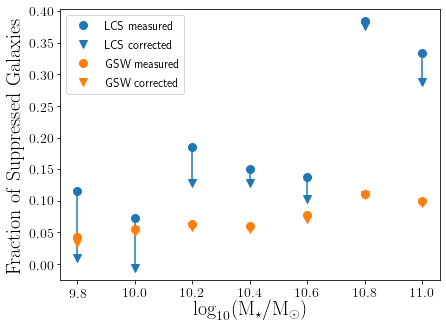

In [185]:
plt.figure()
yerr = lcsfrac - lcsfrac_lower
yerr2 =np.zeros((2,len(yerr)))
yerr2[0,:] = yerr
plt.plot(lcsMstar,lcsfrac,'o',color=mycolors[0], label='LCS measured',markersize=8)
plt.plot(lcsMstar,lcsfrac_lower,'v',color=mycolors[0], label='LCS corrected',markersize=8)
plt.errorbar(lcsMstar,lcsfrac,yerr=yerr2,fmt='o')
plt.plot(gswMstar,gswfrac,'o',color=mycolors[1], label='GSW measured',markersize=8)
plt.plot(gswMstar,gswfrac_lower,'v',color=mycolors[1], label='GSW corrected',markersize=8)
plt.legend()
plt.xlabel(r'$\rm \log_{10}(M_\star/M_\odot)$',fontsize=20)
plt.ylabel(r'$\rm Fraction \ of \ Suppressed \ Galaxies$',fontsize=20)

# Visualize suppressed LCS galaxies

In [1]:
# run again with BT cut so we can determine contamination in BT < 0.3 sample
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 9.7 --ellip 0.75 --HIdef --minssfr -11.5 --cutBT --BT 0.3

Running on Rose's mac pro
outfile =  /Users/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap-BTcut.fits
number of lines in LCS cat =  2955
inside LCS cut_BT, BT =  0.3
inside LCS cut_BT, BTkey =  __B_T_r


/Users/rfinn/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/rfinn/github/LCS/python/lcs_paper2_v2.py:1159: RuntimeWarning: divide by zero encountered in log10
  self.sb_obs[mipsflag]=(self.cat['fcmag1'][mipsflag] + 2.5*np.log10(np.pi*((self.cat['fcre1'][mipsflag]*mipspixelscale)**2)*self.cat['fcaxisratio1'][mipsflag]))


got sb flag
1305 1305 1305 1305


/Users/rfinn/github/LCS/python/lcs_paper2_v2.py:1136: RuntimeWarning: divide by zero encountered in log10
  self.NUV = 22.5 - 2.5*np.log10(self.cat['NMGY'][:,1])
/Users/rfinn/github/LCS/python/lcs_paper2_v2.py:1136: RuntimeWarning: invalid value encountered in log10
  self.NUV = 22.5 - 2.5*np.log10(self.cat['NMGY'][:,1])
/Users/rfinn/github/LCS/python/lcs_paper2_v2.py:1137: RuntimeWarning: divide by zero encountered in log10
  self.MAG24 = 2.5*np.log10(3631./(self.cat['FLUX24']*1.e-6))


In [3]:
cat = b.lcs.cat
all_passive = cat['logSFR'] < get_SFR_cut(cat['logMstar'])
all_sf = cat['logSFR'] > get_SFR_cut(cat['logMstar'])
dsfr = cat['logSFR'] - get_MS(cat['logMstar'])
mass_flag = cat['logMstar'] > 9.7
suppressed = all_sf & (dsfr < -1*MS_OFFSET) & mass_flag & (b.lcs.membflag | b.lcs.infallflag)
print('number of suppressed galaxies = {}'.format(np.sum(suppressed)))

number of suppressed galaxies = 46


In [5]:
# write out catalog of suppressed galaxies
outfile = homedir+'/research/LCS/tables/LCS_BT0p3_suppressed.fits'
colnames = ['ObjID_1','RA_1','DEC_1','logMstar','logSFR','__B_T_r','HIdef_Boselli','CLUSTER_1','NSAID']
newnames = ['ObjID','RA','DEC','logMstar','logSFR','B_T_r','HIdef_Boselli','CLUSTER','NSAID']
newtab  = Table(cat[suppressed][colnames],names = newnames)
newtab.write(outfile,format='fits',overwrite=True)

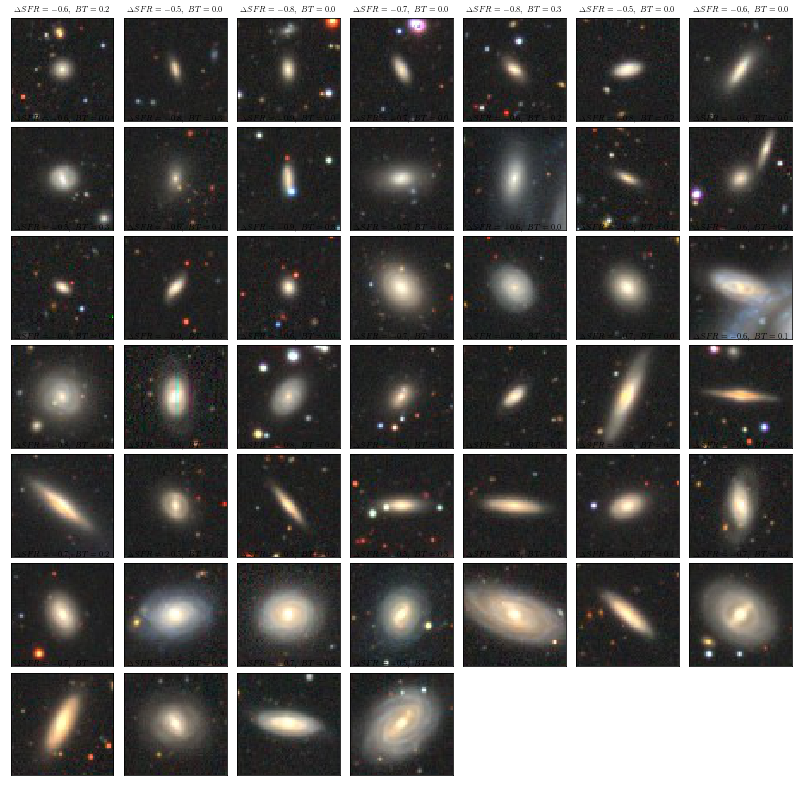

In [228]:
b.get_legacy_images_1flag(suppressed,sortbymass=True)
plt.savefig('LCSsuppressed_collage.png')
plt.savefig('LCSsuppressed_collage.pdf')

## Using LCS to fit passive peaks

* doesn't work b/c fits to SF and passive peaks are less certain due to smaller sample size.

outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap.fits
number of lines in LCS cat =  2955
got sb flag
2759 2759 2759 2759
STD of pruned data = 0.18
STD of full data = 0.19
##################################
### FITTING WITH SIGMA CLIPPING 
##################################
Best-fit slope = 0.40
Best-fit inter = -4.16
Width of the MS = 0.19 (unclipped data)
###################################
### FITTING MS AFTER SIGMA CLIPPING 
###################################
Best-fit slope = 0.40+/-0.05
Best-fit inter = -4.16+/-0.54
SFR-Mstar best fit line :  [  -57.31788878  1142.90647478 -5659.04639554]
sqrt of cov matrix = , 4.013e+03, 1.636e+06, 4.146e+07
mean STD of MS = -1.73
median STD of MS = 0.34
average SFR of where gaussians overlap = -1.87
median SFR of where gaussians overlap = -1.25
mean offset from MS = -2.59
median offset from MS = -1.83
median Zscore of offset = -0.92
outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-

<Figure size 489.6x360 with 0 Axes>

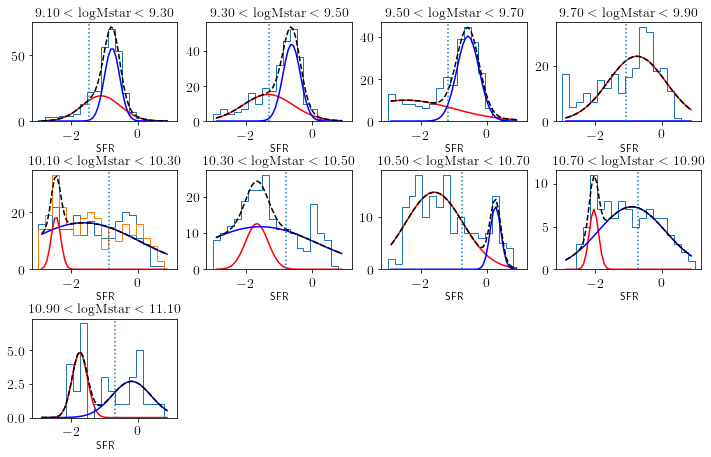

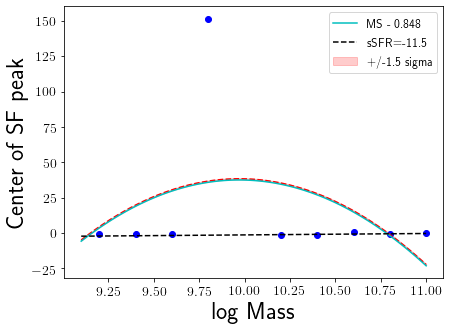

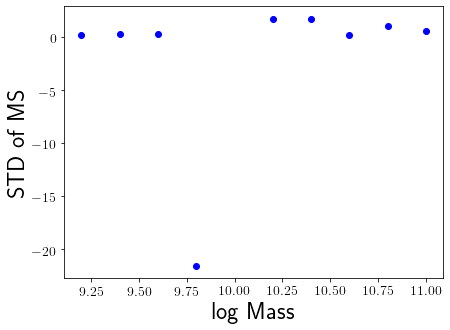

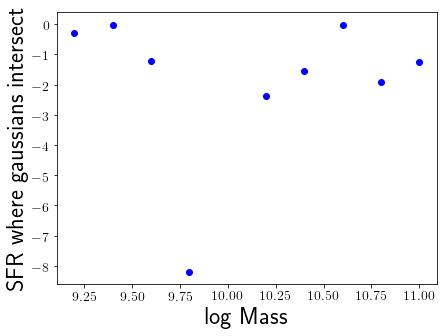

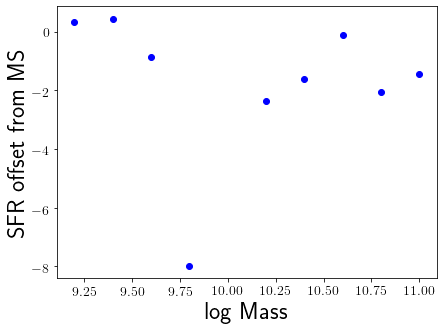

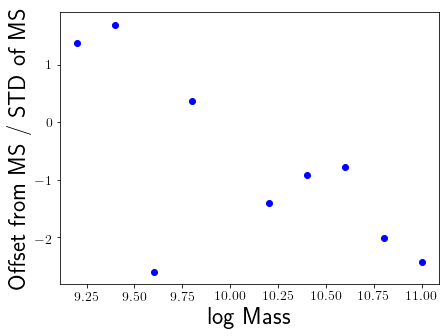

In [75]:
# our sample w/out B/T cut to get the field sample fits
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 9.7 --ellip 0.75 --HIdef --minssfr -11.5

gauss_minmass,gauss_maxmass,lower_peak_fit,higher_peak_fit = separate_sf(b.lcs.cat['logMstar'],b.lcs.cat['logSFR'],m1=9.1,m2=11,ms_slope=0.592,ms_intercept=-6.05,dm=.2)

# run again with BT cut so we can determine contamination in BT < 0.3 sample
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 9.7 --ellip 0.75 --HIdef --minssfr -11.5 --cutBT --BT 0.3



Text(0.9, 0.5, 'Total Contam = 0.9')

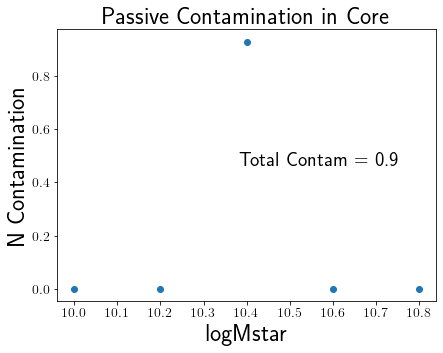

In [76]:
logMstar = []
Ncontam = []
Nsf_lcs = []
Nsuppressed_lcs = []
for i,gaussfit in enumerate(lower_peak_fit):
    if gauss_minmass[i] < 9.7:
        continue
    avemass = 0.5*(gauss_minmass[i]+gauss_maxmass[i])
    sfrcut = get_SFR_cut(avemass)
    
    # integrate gauss fit below
    int_below = integrate.quadrature(gaussian1,-10,sfrcut,tuple(gaussfit))[0]
    # integrate gauss fit below
    int_above = integrate.quadrature(gaussian1,sfrcut,10,tuple(gaussfit))[0]
    # get number of LCS galaxies in mass range and below passive cut
    flag = b.lcs.membflag & (b.lcs.cat['logMstar'] > gauss_minmass[i]) & (b.lcs.cat['logMstar'] <= gauss_maxmass[i]) & (b.lcs.cat['logSFR'] < sfrcut)
    N_lcs_passive = np.sum(flag)
    
    scale = N_lcs_passive/int_below
    
    Ncontam.append(scale*int_above)
    logMstar.append(avemass)
    
plt.figure()
plt.plot(logMstar,Ncontam,'o')
plt.xlabel('logMstar')
plt.ylabel('N Contamination')
plt.title('Passive Contamination in Core')
s = 'Total Contam = {:.1f}'.format(np.sum(Ncontam))
plt.text(0.9,0.5,s,transform=plt.gca().transAxes,horizontalalignment='right')

# Other plots

SFR-Mstar best fit line :  [ -0.19689988   4.4186588  -24.60739556]
sqrt of cov matrix = , 3.073e-03, 1.230e+00, 3.061e+01
mean STD of MS = 0.29
median STD of MS = 0.29
average SFR of where gaussians overlap = -0.52
median SFR of where gaussians overlap = -0.52
mean offset from MS = -0.64
median offset from MS = -0.60
median Zscore of offset = -1.70


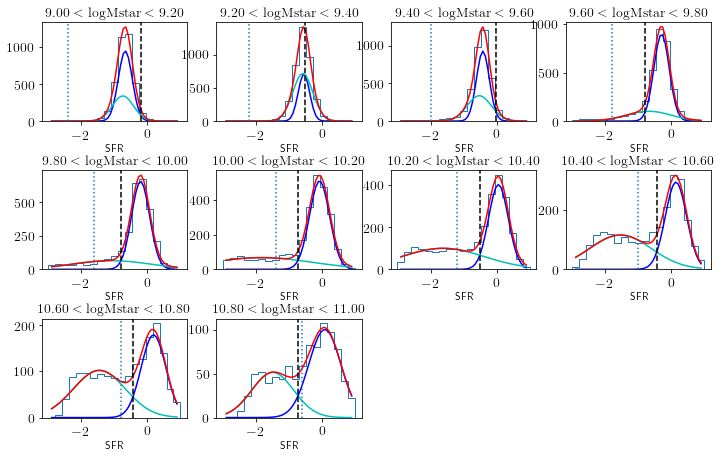

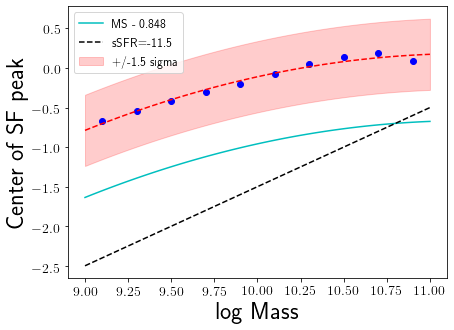

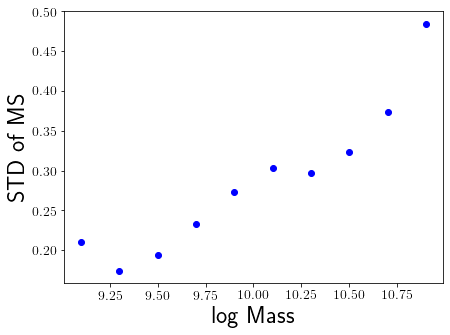

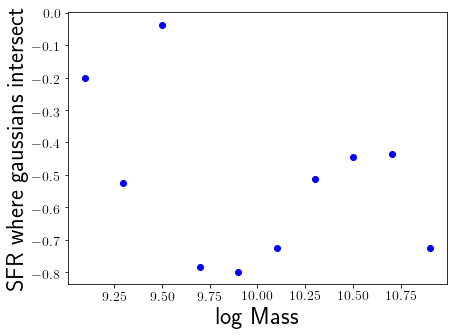

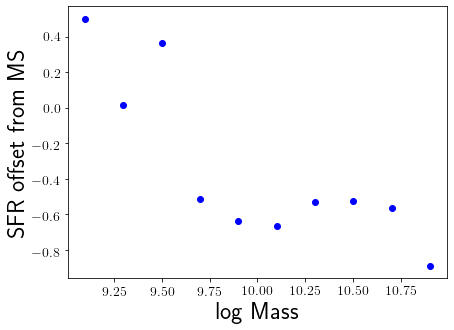

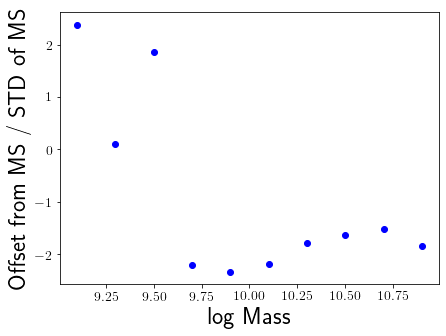

In [15]:
t = separate_sf(b.gsw.cat['logMstar'],b.gsw.cat['logSFR'],m1=9.,m2=11,ms_slope=0.592,ms_intercept=-6.05,dm=.2)

# comparing MS with and without BT cut

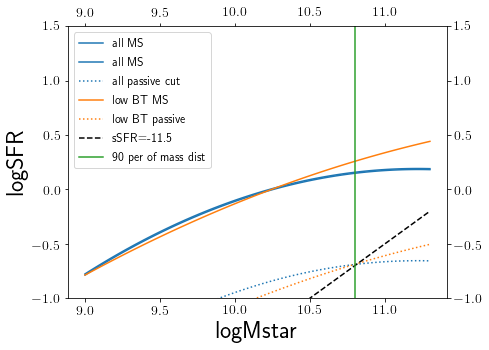

In [121]:
plt.figure()
xline = np.linspace(9,11.3,100)
yline = -0.1969*xline**2 +  4.4187*xline  -24.607
plt.plot(xline,yline,label='all MS',c=mycolors[0])
yline = -0.197*xline**2 +  4.42*xline  -24.6
plt.plot(xline,yline,label='all MS',c=mycolors[0])
#plt.plot(xline,yline-.45,label='all',ls='--')
plt.plot(xline,yline-.848,label='all passive cut',ls=':',c=mycolors[0])
# with BT cut
a,b,c = -0.09348908,   2.4324918,  -15.1074248
yline_lowBT = a*xline**2+b*xline+c 
plt.plot(xline,yline_lowBT,label='low BT MS',c=mycolors[1])
plt.plot(xline,yline_lowBT-.947,label='low BT passive',ls=':',c=mycolors[1])


plt.plot(xline,xline-11.5,ls='--',c='k',label='sSFR=-11.5')
plt.ylim(-1,1.5)
plt.axvline(x=10.8,label='90 per of mass dist',c=mycolors[2])

#plt.axvline(x=10.9)

#yline_lowBT_lomass8p5= 5.43557484e-04*xline**2 + 5.60202352e-01*xline -5.82658889e+00
#plt.plot(xline,yline_lowBT_lomass8p5,label='low mass cut 8.5')
plt.legend()
plt.xlabel('logMstar')
plt.ylabel('logSFR')
#plt.axhline(y=.145)
plt.gca().tick_params(right=True, top=True, labelright=True, labeltop=True)

# Using GSWLC, cut in redshift only

But we have already excluded a large part of the passive sequence because we have removed AGN.  What if we repeat the same procedure, but we use the full GSWLC, just limiting to the redshift range of the LCS.

In [13]:
gswlcs = Table.read(homedir+'/research/GSWLC/GSWLC-X2-LCS-Zoverlap.dat')

SFR-Mstar best fit line :  [ -0.12188612   2.91252827 -17.11201236]
sqrt of cov matrix = , 0.001, 0.283, 7.045
average SFR of where gaussians overlap = -0.56
median SFR of where gaussians overlap = -0.58
mean offset from MS = -0.64
median offset from MS = -0.64
mean STD of MS = 0.30
median STD of MS = 0.30
median Zscore of offset = -1.83


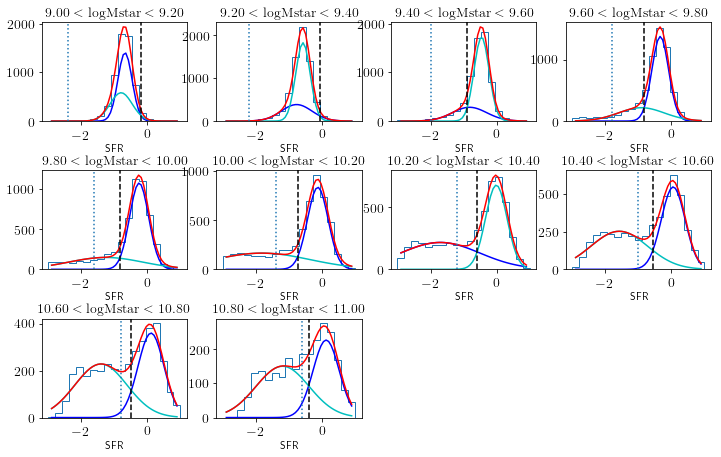

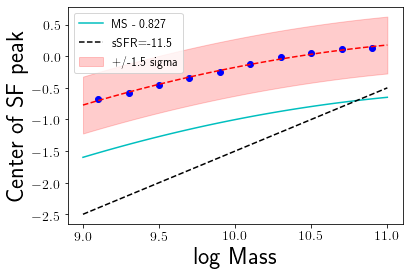

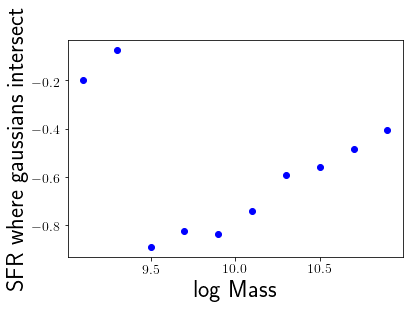

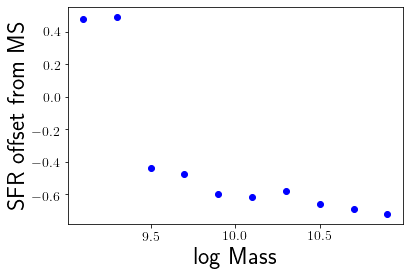

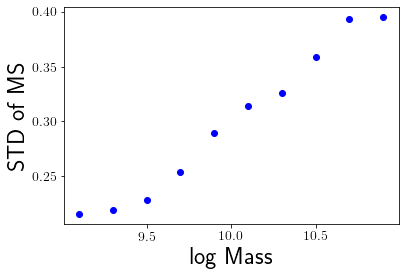

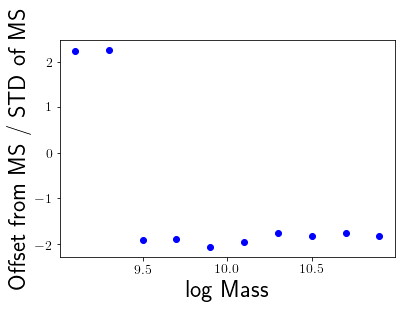

In [253]:
separate_sf(gswlcs['logMstar'],gswlcs['logSFR'],m1=9.,m2=11,ms_slope=.553,ms_intercept=-5.71,dm=.2)

In [262]:
logmass = 10.7
yms = -.121886*logmass**2+2.912528*logmass-17.1120
print("offset b/w MS and sSFR=-11.5 = {:.3f} ".format(yms- (logmass-11.5)))
print("offset relative to MS sigma = {:.3f}".format((yms- (logmass-11.5))/.3))

offset b/w MS and sSFR=-11.5 = 0.897 
offset relative to MS sigma = 2.991


In [250]:
10.**.827

6.714288529259523

In [251]:
.827-.45

0.37699999999999995

# offset of passive cut 

how to pick the mass where we define the offset relative to MS.  could use a percentile of LCS mass

In [260]:
lcsflag = (b.lcs.membflag | b.lcs.infallflag) & (b.lcs.cat['logMstar'] > 9.7) & (b.lcs.cat['logSFR']-b.lcs.cat['logMstar'] > -11.5)
logmstar = b.lcs.cat['logMstar'][lcsflag]
from scipy.stats import scoreatpercentile
print("percentile mass of LCS sample = {:.3f}".format(scoreatpercentile(logmstar,90)))

percentile mass of LCS sample = 10.652


In [261]:
flag =   (b.gsw.cat['logMstar'] > 9.7) & (b.gsw.cat['logSFR']-b.gsw.cat['logMstar'] > -11.5)
logmstar = b.gsw.cat['logMstar'][flag]
from scipy.stats import scoreatpercentile
print("percentile mass of field sample = {:.3f}".format(scoreatpercentile(logmstar,90)))

percentile mass of field sample = 10.707


In [241]:
.834-.45

0.38399999999999995

SFR-Mstar best fit line :  [ 0.84040107 -8.57044881]
sqrt of cov matrix =  [0.17484143 1.70619768]
average SFR of where gaussians overlap = -0.66
median SFR of where gaussians overlap = -0.55
mean offset from MS = -0.83
median offset from MS = -0.63
mean STD of MS = 0.43
median STD of MS = 0.28
median Zscore of offset = -1.26


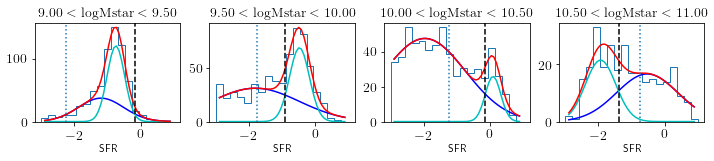

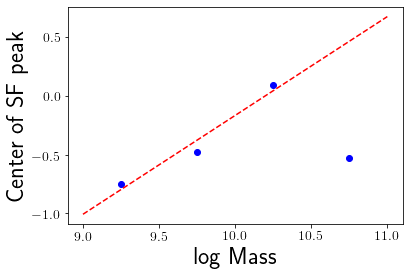

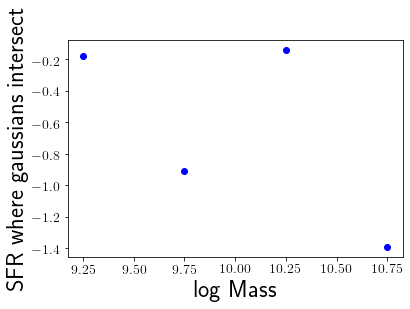

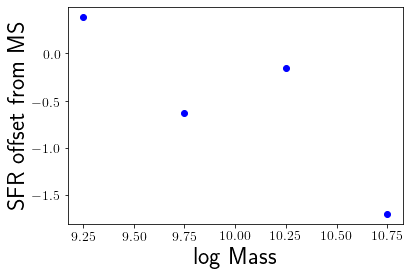

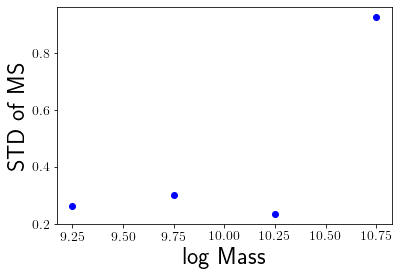

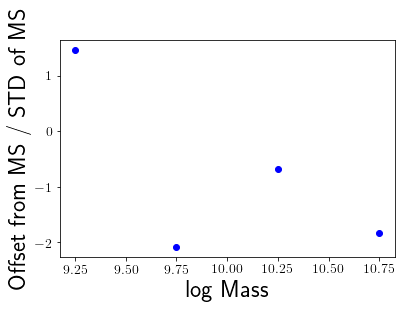

In [171]:
separate_sf(b.lcs.cat['logMstar'],b.lcs.cat['logSFR'],m1=9.,m2=11,ms_slope=0.592,ms_intercept=-6.05,dm=.5)

SFR-Mstar best fit line :  [ -0.05765684   1.81899459 -12.63361194]
sqrt of cov matrix = , 2.468e-02, 9.876e+00, 2.457e+02
mean STD of MS = 0.23
median STD of MS = 0.25
average SFR of where gaussians overlap = -0.43
median SFR of where gaussians overlap = -0.42
mean offset from MS = -0.65
median offset from MS = -0.77
median Zscore of offset = -2.59


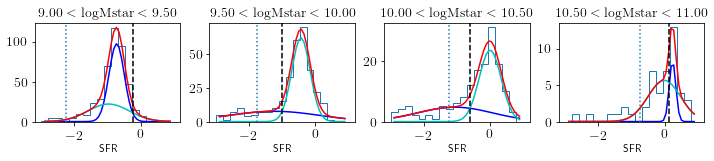

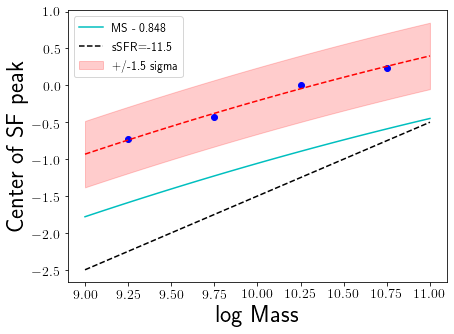

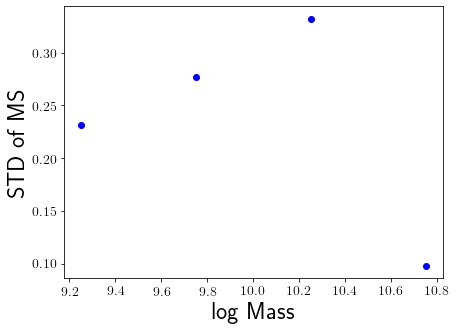

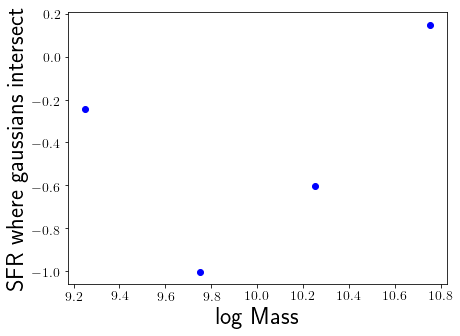

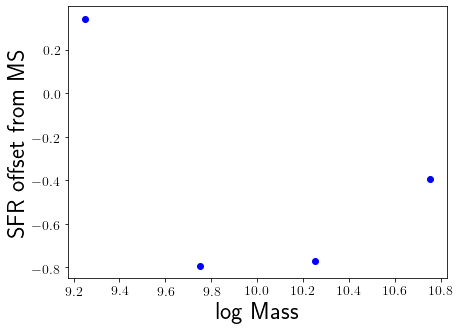

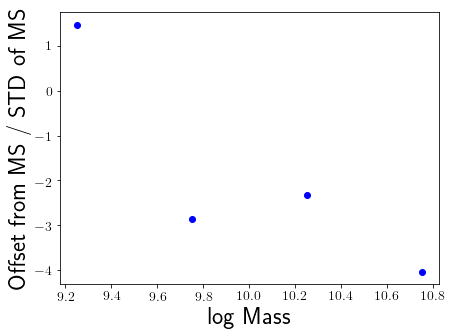

In [126]:
flag = (b.lcs.cat['__B_T_r'] < 0.3) & (b.lcs.membflag | b.lcs.infallflag)
lcsBTcut = b.lcs.cat[flag]
separate_sf(lcsBTcut['logMstar'],lcsBTcut['logSFR'],m1=9.,m2=11,ms_slope=0.754,ms_intercept=-7.56,dm=.5)

# Discussion

* looking at passive vs SF peaks in field and cluster

In [123]:
# plot main sequence
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 9.7 --ellip 0.75 --HIdef --minssfr -11.5


outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap.fits
number of lines in LCS cat =  2955
got sb flag
2759 2759 2759 2759
STD of pruned data = 0.18
STD of full data = 0.19
##################################
### FITTING WITH SIGMA CLIPPING 
##################################
Best-fit slope = 0.40
Best-fit inter = -4.16
Width of the MS = 0.19 (unclipped data)
###################################
### FITTING MS AFTER SIGMA CLIPPING 
###################################
Best-fit slope = 0.40+/-0.05
Best-fit inter = -4.16+/-0.54


<Figure size 489.6x360 with 0 Axes>

SFR-Mstar best fit line :  [ -0.09348908   2.4324918  -15.1074248 ]
sqrt of cov matrix = , 4.140e-04, 1.657e-01, 4.124e+00
mean STD of MS = 0.27
median STD of MS = 0.27


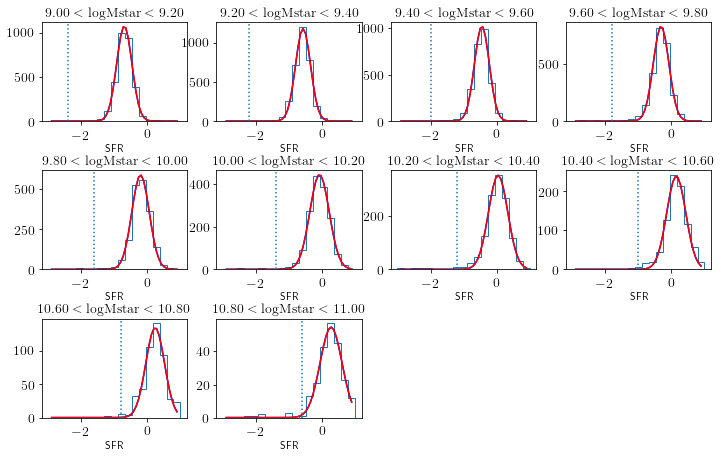

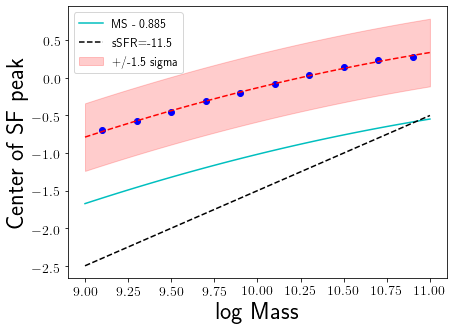

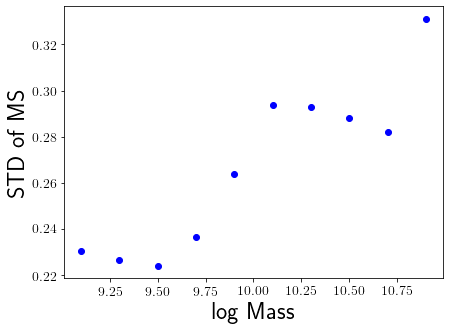

In [124]:
flag = b.gsw.cat['__B_T_r'] < 0.3
gswBTcut = b.gsw.cat[flag]
separate_sf(gswBTcut['logMstar'],gswBTcut['logSFR'],m1=9,m2=11,ms_slope=0.754,ms_intercept=-7.56,dm=.2,passive_cut=0.885,twogauss=False)

SFR-Mstar best fit line :  [ -0.23547696   5.26677435 -29.30554284]
sqrt of cov matrix = , 1.043e-02, 4.176e+00, 1.039e+02
mean STD of MS = 0.39
median STD of MS = 0.32


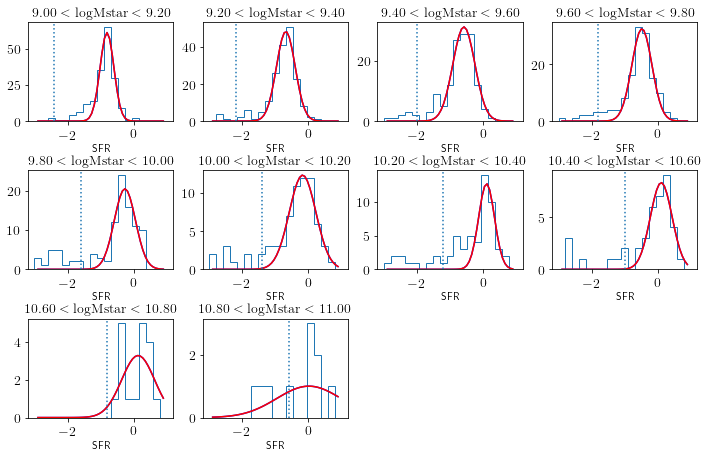

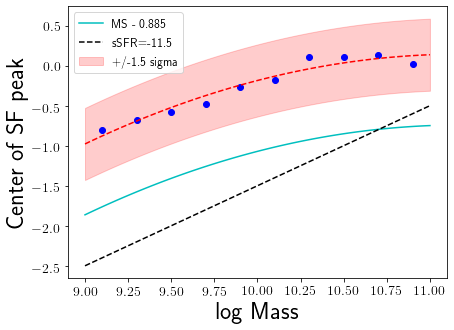

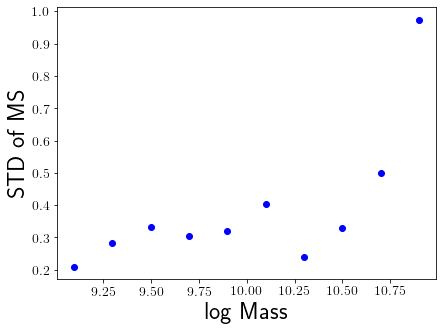

In [125]:
flag = b.lcs.cat['__B_T_r'] < 0.3
lcsBTcut = b.lcs.cat[flag]
separate_sf(lcsBTcut['logMstar'],lcsBTcut['logSFR'],m1=9,m2=11,ms_slope=0.754,ms_intercept=-7.56,dm=.2,passive_cut=0.885,twogauss=False)

# Illustrating contamination calculation

# Using full GSWLC

In [66]:
gsw = Table.read(homedir+'/research/GSWLC/GSWLC-X2.dat',format='ascii')

SFR-Mstar best fit line :  [ 0.7988648 -7.92889  ]
sqrt of cov matrix =  [0.03095352 0.30050428]
average SFR of where gaussians overlap = -0.57
median SFR of where gaussians overlap = -0.57
mean offset from MS = -0.92
median offset from MS = -0.86
mean STD of MS = 0.37
median STD of MS = 0.31
median Zscore of offset = -2.05


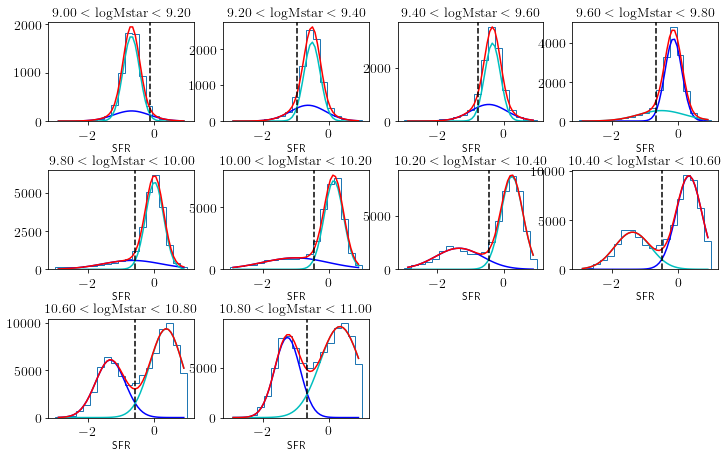

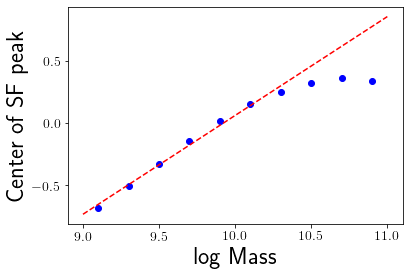

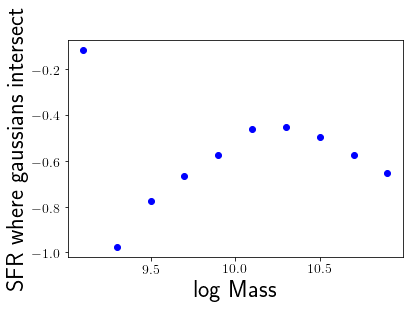

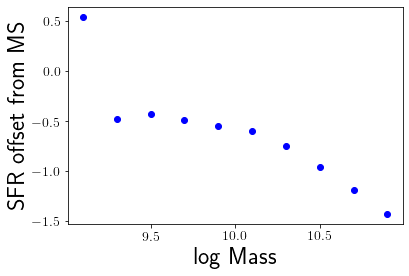

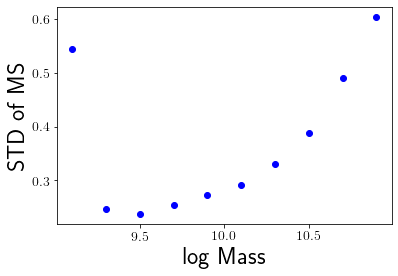

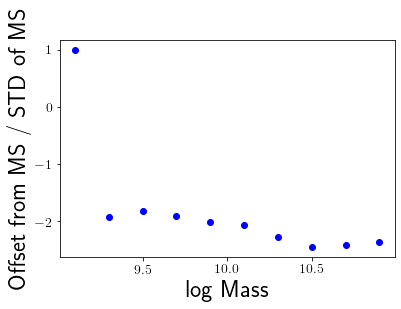

In [159]:
separate_sf(gsw['logMstar'],gsw['logSFR'],m1=9,m2=11,ms_slope=.799,ms_intercept=-7.93,dm=.2)

# Summary of fits

Text(0, 0.5, 'logSFR')

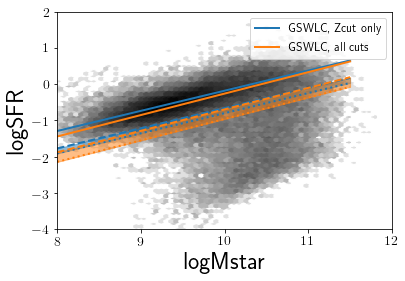

In [161]:
mycolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure()
plt.hexbin(gswlcs['logMstar'],gswlcs['logSFR'],cmap='gray_r',gridsize=75,bins='log')
xline = np.linspace(8,11.5,100)
# from GSWLC with LCS z cut
yline = .556*xline-5.74
STD = 0.32
offset = -0.62
plt.plot(xline,yline,lw=2,c=mycolors[0],label='GSWLC, Zcut only')
plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[0])
plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[0])
plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[0],alpha=.5)

# from GSWLC, cut according to AGC, Simard, etc
STD = 0.29
offset = -0.7
yline = 0.592*xline -6.18
plt.plot(xline,yline,lw=2,c=mycolors[1],label='GSWLC, all cuts')
plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[1])
plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[1])
plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[1],alpha=.5)
plt.legend()


# from full GSWLC
STD = 0.3
offset = -0.82
yline = 0.799*xline -7.92
#plt.plot(xline,yline,lw=2,c=mycolors[2],label='GSWLC')
#plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[2])
#plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[2])
#plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[2],alpha=.5)
plt.legend()
plt.axis([8,12,-4,2])
plt.xlabel('logMstar')
plt.ylabel('logSFR')

No handles with labels found to put in legend.


[8, 12, -4, 2]

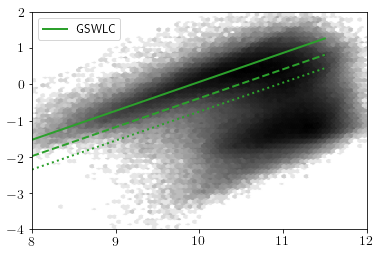

In [157]:
mycolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure()
plt.hexbin(gsw['logMstar'],gsw['logSFR'],cmap='gray_r',gridsize=75,bins='log',extent=(8,12,-4,2))
xline = np.linspace(8,11.5,100)
# from GSWLC with LCS z cut
yline = .556*xline-5.74
STD = 0.32
offset = -0.62
#plt.plot(xline,yline,lw=2,c=mycolors[0],label='GSWLC, Zcut only')
#plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[0])
#plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[0])
#plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[0],alpha=.5)

# from GSWLC, cut according to AGC, Simard, etc
STD = 0.29
offset = -0.7
yline = 0.592*xline -6.18
#plt.plot(xline,yline,lw=2,c=mycolors[1],label='GSWLC, all cuts')
#plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[1])
#plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[1])
#plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[1],alpha=.5)
plt.legend()


# from full GSWLC
STD = 0.3
offset = -0.82
yline = 0.799*xline -7.92
plt.plot(xline,yline,lw=2,c=mycolors[2],label='GSWLC')
plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[2])
plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[2])
#plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[2],alpha=.5)
plt.legend()
plt.axis([8,12,-4,2])